In [1]:
#pip install rank_bm25

In [2]:
#mandatory imports
import time
from Bio import Entrez
import pandas as pd
import numpy as np
import spacy
import urllib.request, urllib.error, urllib.parse
import json
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from rank_bm25 import BM25Okapi
print("Done.")

Done.


In [3]:
## Thesaurus declaration
thesaurus = {
    "Ivermectin" : ["IVM", "Ivermectin", "Avermectin", "avermectin", "ivermectin", "stromectol", "Stromectol", "Eqvalan", "Ivomec", "Mectizan", "Dihydroavermectin", "MK 933", "MK-933", "MK933","MK-0933", "L 640471", "L-640471", "C48H74O14", "IV", "IVM-654", "IVR-25", "IV-104", "IVE-11", "IVER-15"],
    "GABA" : ["GABA", "GABAergic", "gamma-aminobutyric acid"],
    "Zebrafish" : ["Zebrafish", "Danio rerio"],
    "COVID-19" : ["COVID-19", "COVID", "SARS-CoV-2"],
    "Glutamate" : ["Glutamate", "glutamate","Glu", "L-(+)-glutamate","L-Glu", "L-Glutamate", "L-glutamate", "L glutamate", "L glutamate"]
}
print("Done.")

Done.


In [4]:
def global_db_search(query_list, genes_list=[]):

    if len(genes_list) != 0:
        for i in query_list:
            for j in genes_list:
                query = i + j + "[tiab]"

                handle = Entrez.egquery(term=query)
                record = Entrez.read(handle)
                df = pd.DataFrame(record["eGQueryResult"]).head(2)
                df["Query"] = query
                append_data(df, 'global_query_res.csv', False)
                time.sleep(0.34)
    else:
        for i in query_list:
            handle = Entrez.egquery(term=i)
            record = Entrez.read(handle)
            df = pd.DataFrame(record["eGQueryResult"]).head(2)
            df["Query"] = i
            append_data(df, 'global_query_res.csv', False)
            time.sleep(0.34)
    return


## Function for reading in the df "summary" results
def read_in_results(file_name):

    # The converters are there so that each list is NOT inside a string
    res_df = pd.read_csv(file_name,  converters={"MainID_List": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "P_Dates": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "P_Years": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "LinkedID_List": lambda x: x.strip("[]").replace("'", "").split(", "),
                                                    "Query_Count": int})
    return res_df


def esummary_info(in_webenv_key, in_query_key, db_name):

    # Obtaining DocSums for a set of IDs that are stored on the Entrez History server.
    handle = Entrez.esummary(db=db_name, webenv=in_webenv_key, query_key=in_query_key)
    record = Entrez.read(handle)

    publ_dates, publ_years = get_published_dates(record)

    if db_name == "pubmed":
        ids_list = get_pmcids(record)
    else:
        ids_list = get_pmids(record)

    return publ_dates, publ_years, ids_list


def get_published_dates(esummary_rec):

    retr_dates = []
    retr_years = []
    check = True
    i = 0
    for article in esummary_rec:
        # "PubDate" is often of the form: '2021 Nov 26'
        retr_dates.append(article["PubDate"])
        date = article["PubDate"].split()
        while(i < 2):
            if len(date[i]) == 4:
                p_year = int(date[i])
                i = 3
            else:
                i = i + 1
        #p_year = int(article["PubDate"].split()[0])
        #p_year = int(article["P_Years"].split()[0])
        #changed from PubDate to P_Years because of error when changing search term
        retr_years.append(p_year)

    return retr_dates, retr_years


def get_pmcids(esummary_rec):

    pmcids_list = []
    for i in esummary_rec:
        # If "pmc" is there, then this article also has a PMCID (i.e., it's also found in the PubMed Central db)
        if "pmc" in i["ArticleIds"]:
            pmcids_list.append(i["ArticleIds"]["pmc"])
        else:
            pmcids_list.append(np.NaN)

    return pmcids_list


def get_pmids(esummary_rec):

    pmids_list = []
    for i in esummary_rec:
        # '0' means that the article has no PMID (i.e., it's not found in the PubMed db)
        if i["ArticleIds"]["pmid"] == '0':
            pmids_list.append(np.NaN)
        else:
            pmids_list.append(i["ArticleIds"]["pmid"])

    return pmids_list


## Function that retrieves summary results from a given set of queries (which don't require a gene list)
def get_query_info_no_genes(query_in, db_name):

    # relevance: Records are sorted based on relevance to your search. (Relevance ranking)
    search_results = Entrez.read(
        Entrez.esearch(db=db_name, term=query_in, sort="relevance", retmax=5000, usehistory="y")
        )

    # NEED TO FIRST CHECK IF WE GOT ANY RESULTS FROM THAT QUERY
    if len(search_results["IdList"]) == 0:
        print("No Results.")
        return
    else:
        # With search_results, we will use its WebEnv value and QueryKey value
        p_dates, p_years, ids_list = esummary_info(search_results["WebEnv"], search_results["QueryKey"], db_name)

        time.sleep(0.34)

        return pd.DataFrame([[query_in, db_name, search_results['Count'], search_results['IdList'], p_dates, p_years, ids_list]],
                                columns=['Query', 'Db_Name', 'Query_Count', 'MainID_List', 'P_Dates', 'P_Years', 'LinkedID_List'])


## Function that retrieves summary results from a given set of queries (which requires a gene list)
def get_query_info(query_in, genes, db_name):

    gene_query = []
    query = ""

    for i in genes:
        # Example of db_name values in this use case: "pubmed" or "pmc"
        if db_name == "pubmed":
            # PubMed's Search field tag: Title/Abstract [tiab]
            query = query_in + i + "[tiab]"
        else:
            query = query_in + i

        # relevance: Records are sorted based on relevance to your search. (Relevance ranking)
        search_results = Entrez.read(
            Entrez.esearch(db=db_name, term=query, sort="relevance", retmax=5000, usehistory="y")
            )
     
        # NEED TO FIRST CHECK IF WE GOT ANY RESULTS FROM THAT QUERY
        if len(search_results["IdList"]) == 0:
            continue

        # With search_results, we will use its WebEnv value and QueryKey value
        p_dates, p_years, ids_list = esummary_info(search_results["WebEnv"], search_results["QueryKey"], db_name)
       
        gene_query.append([query, db_name, search_results['Count'], search_results['IdList'], p_dates, p_years, ids_list])
        time.sleep(0.34)
          
    return pd.DataFrame(gene_query, columns=['Query', 'Db_Name', 'Query_Count', 'MainID_List', 'P_Dates', 'P_Years', 'LinkedID_List'])


## Function for obtaining citation counts for the set of IDs found in the "summary" df
def cited_cnt_table(df_summary, db_name):

    elink_data = []
    link_name = ""

    if db_name == "pubmed":
        link_name = "pubmed_pubmed_citedin"
    else:
        link_name = "pmc_pmc_citedby"  # "pmc" is the other db_name in this use case

    for i in range(0, len(df_summary)):

        query_term = df_summary.iloc[i]["Query"]

        for id_num in df_summary.iloc[i]["MainID_List"]:

            record = Entrez.read(Entrez.elink(id=id_num, dbfrom=db_name, db=db_name, linkname=link_name))
         
            if len(record[0]["LinkSetDb"]) != 0:
                cited_counts = len(record[0]["LinkSetDb"][0]["Link"])
            else:
                # 'LinkSetDb' key contains empty list when an article has no citation counts
                cited_counts = 0
            elink_data.append([query_term, db_name, id_num, cited_counts])

            if (df_summary.iloc[i]["MainID_List"].index(id_num) + 1) % 3 == 0:
                time.sleep(0.34)

    return pd.DataFrame(elink_data, columns=["Query", "Db_Name", "Id_List", "Citation_Cnts"]) 


## Function that returns the Top-k results (pass in k as an argument to the function, input by the user)
def get_top_k(df, k_val):

    q_top_k = []

    for q in df["Query"].unique():
        matches_ids = []  # For each query version, these are the IDs meeting the criteria of having citation counts >= 25
        counts = []
        df_temp = df[df["Query"] == q]

        for i in range(0, len(df_temp)):
            if df_temp.iloc[i]["Citation_Cnts"] >= 25:
                matches_ids.append(int(df_temp.iloc[i]["Id_List"]))
                counts.append(df_temp.iloc[i]["Citation_Cnts"])
                if len(matches_ids) == k_val:
                    break
        if len(matches_ids) == 0:
            continue
        q_top_k.append([q, matches_ids, counts])

    top_k_df = pd.DataFrame(q_top_k, columns=["Query", "Top_"+str(k_val)+"_Ids", "Citation_Cnts"])

    return top_k_df


## Function that appends DataFrame rows to a CSV file
def append_data(df, file_name, is_new_file):

    if is_new_file:
        # if True, then
        df.to_csv(file_name, index=False)
    else:
        # False: This is an existing CSV file
        df.to_csv(file_name, mode='a', index=False, header=False)

    return

In [5]:
# Load in the model for English
nlp = spacy.load("en_core_web_sm")
# Can't retrieve XML if you don't have a query.
query = "GABA AND Glutamate"
Entrez.email = "n01365801@unf.edu.com"
df_q_pubmed = get_query_info_no_genes(query, "pubmed")
print("Done.")

Done.


In [6]:
"""
Documentation for fetch_pubmed()

This function's purpose is to use NCBI's E-Utils to get the body of articles, given an id.
The E-Util used in E-Fetch.
Future Work on this could be adjusting the argument, to allow for just a list of IDs, instead of a Pandas DataFrame slice.

Arguments:
    * ids: The IDs of articles from a Pandas DataFrame
Return Value: A list of the records.
"""
def fetch_pubmed(ids): 
    i = 0
    records_pubmed = []
    # Fetch all records pertaining to our queries.
    for row in ids:
        for uid in row:
            i = i + 1
            try:
                handle = Entrez.efetch(db="pubmed", id=uid, retmode="xml")
                record = Entrez.read(handle, validate=False)
                records_pubmed.append(record)
            except:
                print("Failure at index" + str(i))
    # Be polite and flush/close the stream like a good programmer.
    handle.close()
    return records_pubmed
print("Done.")

Done.


In [7]:
df_q_pubmed.head()

,Query,Db_Name,Query_Count,MainID_List,P_Dates,P_Years,LinkedID_List
0,GABA AND Glutamate,pubmed,21959,"[33454439, 33438215, 35852458, 35840907, 32536...","[2022 Oct 7, 2022 Sep 24, 2022, 2022 Sep, 2022...","[2022, 2022, 2022, 2022, 2022, 2022, 2022, 202...","[nan, nan, PMC9530601, nan, nan, nan, PMC95312..."


In [8]:
records_pubmed = fetch_pubmed(df_q_pubmed['MainID_List'])


print(len(records_pubmed))
print("Done.")

Failure at index637
Failure at index901
Failure at index1703
Failure at index2248
Failure at index3311
Failure at index3517
Failure at index4054
Failure at index4729
Failure at index4830
4991
Done.


In [9]:
"""
Documentation for invert_dict()

This function's sole purpose is to invert a dictionary, so that the values of the old are the keys of the new,
and the keys of the old are the values of the new, in list format.

Arguments:
    dictionary: The dictionary to be inverted.
Return Value: The inverted dictionary following the above design.
"""
def invert_dict(dictionary):
    dict_inverted = {} # output
    for (k, v) in dictionary.items():
        if v in dict_inverted.keys():
            dict_inverted[v].append(k)
        else:
            dict_inverted[v] = [k]
            
    return dict_inverted
print("Done.")

Done.


In [10]:
"""
Documentation for find_comentions()

Future Work for this function includes generalizing it to be able to handle both PubMed and PMC.
This will likely require some work on reranking() below, as it only handles PubMed formatted XML,
due to issues with PMC and Biopython present while writing this code.

Arguments:
    * thes: A dictionary containing the synonyms of query terms.
    * doc: A SpaCy Doc object that contains the text we are looking at.
Return Value: A tuple in the form of (sentences, proximity list)
"""
def find_comentions(thes, doc):
    sentences = []
    proximity_list = []
    #print(doc)
    
    for sentence in doc.sents:
        #print(sentence)
        prev_term = ""
        term_seen = False
        first_i = 0
        for word in sentence:
            #print(word.text + str(word.i))
            for term in thes.keys():
                #print(term)
                if term_seen:
                    if (word.text in thes[term]) and (word.text not in thes[prev_term]):
                        #print(word.text + "Calculated!!")
                        #print(word.i)
                        proximity_list.append(int(word.i - first_i))
                        first_i = word.i
                        prev_term = term
                        sentences.append(str(sentence))
                        break
                elif (word.text in thes[term]):
                    #print(word.text)
                    #print(word.i)
                    term_seen = True
                    first_i = word.i
                    prev_term = term
                    break
    
    return (str(sentences), proximity_list)
print("Done.")

Done.


In [11]:
text = "Neurons are metabolically handicapped in the sense that they are not able to perform de novo synthesis of neurotransmitter glutamate and gamma-aminobutyric acid from glucose."
doc = nlp(text)
#print(doc)
query_terms= ["GABA","Glutamate"]
inner_thesaurus = {k:thesaurus[k] for k in query_terms}
(comention_sents, proximity_count) = find_comentions(doc=doc, thes=inner_thesaurus)
print(proximity_count)
if (len(proximity_count) != 0):
    relevancy_score = sum([1/count for count in proximity_count])
else:
    relevancy_score = 0
print(relevancy_score)

[]
0


In [57]:
def bm_reranking(records, query_terms):
    # snippet from https://stackoverflow.com/questions/29216889/slicing-a-dictionary
    # While in the answer, they add a check to make sure the key is in original dict
    # (the thesaurus in this case), it is safe to assume that the key is in the dict,
    # because the thesaurus should contain all possible terms.
    inner_thesaurus = {k:thesaurus[k] for k in query_terms}
    #print(inner_thesaurus)
    # DataFrame Data
    pmids = []
    titles = []
    abstracts = []
    token_abstracts = []
    relevancy_score = {}
    abstract_score = []
    comention_sentences = []
    tokenized_queries = []
    i = 0
    j = 0
    for record in records[100:]:
        # Some records do not have an Abstract (???) so we need to check for an abstract
        # TODO: Deal with the articles that don't have abstracts
        try:
            pmid = str(record['PubmedArticle'][0]['MedlineCitation']['PMID'])
            article_keys = record['PubmedArticle'][0]['MedlineCitation']['Article'].keys()
            if 'Abstract' in article_keys: # We have an Abstract
                # TODO: Stop rewriting this indexing mess every time.
                abstract_text = str(record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'])
                # Process the abstract
                #doc = nlp(abstract_text)
                token_abstracts.append(abstract_text.split(" "))
                #dataframe collection
                pmids.append(pmid)
                titles.append(str(record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle']))
                abstract_text = "".join(str(i) for i in (record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText']))
                abstracts.append(abstract_text)
        except:
            print("Record indexed at " + str(i) + " PMID not found.")
        i = i + 1
        j = j + 1
    
    #bm25 = BM25Okapi(abstracts)
    bm25 = BM25Okapi(token_abstracts)
    #print(abstracts)
    for key in inner_thesaurus.keys():
        tokenized_queries = inner_thesaurus[key] + tokenized_queries
    doc_scores = bm25.get_scores(tokenized_queries)
    print(tokenized_queries)
    #print(doc_scores)
    prerankings = pd.DataFrame(data=[pmids, titles, abstracts, doc_scores]).transpose()
    prerankings.columns = ["PMID", "Title", "Abstract", "BM25 Relevancy Score"]
    prerankings.sort_values(by=["BM25 Relevancy Score"], ascending=False, inplace = True)
    return prerankings.iloc[:15], prerankings

bmtop15,bmrankings =bm_reranking(records_pubmed, ["GABA","Glutamate"])

Record indexed at 4752 PMID not found.
['Glutamate', 'glutamate', 'Glu', 'L-(+)-glutamate', 'L-Glu', 'L-Glutamate', 'L-glutamate', 'L glutamate', 'L glutamate', 'GABA', 'GABAergic', 'gamma-aminobutyric acid']


In [58]:
print(bmtop15)
print(bmrankings[:100])
bmtop15.to_csv("Glutamate and GABA_BM1.csv")
print("Done.")

          PMID                                              Title  \
26    34348699  Characterization of three glutamate decarboxyl...   
2111  11278102  Comparative study of glutamate mediated gamma-...   
2834  10565862  L-glutamate and gamma-aminobutyric acid efflux...   
2975   2865335  Induced release of gamma-aminobutyric acid by ...   
3891  10773201  Transporter-mediated GABA release induced by e...   
550   16620752  Detection of gamma-aminobutyric acid-induced g...   
3098  10684058  [Effects of L-glutamic acid, gamma-aminobutyri...   
3543   1698466  [The cross desensitization and modulation of C...   
1700  19476695  Effects of amino acid neurotransmitters on spo...   
1724  34364429  Rapid quantification of extracellular neurotra...   
0     35077875  Gamma aminobutyric acid (GABA) production in E...   
21    24616376  The selective conversion of glutamic acid in a...   
3556  34343611  Evolution of glutamatergic signaling and synap...   
39    34354048  Ventromedial prefr

In [14]:
"""
Documentation for reranking()

This function will use find_comentions(), invert_dict(), and word_proximity() to create a general ranking of the articles.
The articles will be identified by UID.

Future additions to this reranking function include using Ms. Victoria's get_top_k() and cited_cnt_table() functions to add in the
25 citation requirement for credibility. Other work includes breaking out some functionality into other functions in order to clean up the mess.

Arguments:
    * records: A list of XML Objects returned by E-Fetch.
    * query_terms: A list of query_terms. These then get selected out of the Thesaurus.
Return Value: The rankings for the records. Type is a Pandas DataFrame.
"""
### TODO: Break apart this function into smaller functions
    # Namely, creation of combined_criteria, creation of top_15, and creation of DataFrame
def reranking(records, query_terms):
    # snippet from https://stackoverflow.com/questions/29216889/slicing-a-dictionary
    # While in the answer, they add a check to make sure the key is in original dict
    # (the thesaurus in this case), it is safe to assume that the key is in the dict,
    # because the thesaurus should contain all possible terms.
    inner_thesaurus = {k:thesaurus[k] for k in query_terms}

    # DataFrame Data
    pmids = []
    titles = []
    abstracts = []
    relevancy_score = {}
    comention_sentences = []
    i = 0
    j = 0
    for record in records:
        # Some records do not have an Abstract (???) so we need to check for an abstract
        # TODO: Deal with the articles that don't have abstracts
        try:
            pmid = str(record['PubmedArticle'][0]['MedlineCitation']['PMID'])
            article_keys = record['PubmedArticle'][0]['MedlineCitation']['Article'].keys()
            if 'Abstract' in article_keys: # We have an Abstract
                # TODO: Stop rewriting this indexing mess every time.
                abstract_text = str(record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'])
                # Process the abstract
                doc = nlp(abstract_text)

                (comention_sents, proximity_count) = find_comentions(doc=doc, thes=inner_thesaurus)

                # DataFrame data collection
                pmids.append(pmid)
                if (len(proximity_count) != 0):
                    relevancy_score[pmid] = sum([1/count for count in proximity_count])
                else:
                    relevancy_score[pmid] = 0
                titles.append(str(record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle']))
                try:
                    
                    #FIXME: have to repeat these commands in order to have proper formatting 
                    abstract_text = "".join(str(i) for i in (record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText']))
                    abstracts.append(abstract_text)
                    doc = nlp(abstract_text)
                    (comention_sents, proximity_count) = find_comentions(doc=doc, thes=inner_thesaurus)
                    comention_sentences.append(comention_sents)
                except:
                    print("Reformatting error at " + str(i) + ".")
                
        except:
            print("Record indexed at " + str(i) + " PMID not found.")
        i = i + 1
        j = j + 1
    print("Num records proccessed: " + str(j))
    
    # Relevancy score will be used to calculate the index.
    prerankings = pd.DataFrame(data=[pmids, titles, abstracts, relevancy_score.values(), comention_sentences]).transpose()
    prerankings.columns = ["PMID", "Title", "Abstract", "Relevancy Score", "Comention Sentences"]
    #FIXME: remove plotting
    
    
    
    #formatting for output
    
    
    relevancy_score_inverted = invert_dict(relevancy_score)
    # Gathering the top 15 abstracts based on the relevancy score.
    # We conglomerate all of the scores into a single list, flatten it, and then simply slice out the first 15 elements.
    top_15 = []
    for i in sorted(relevancy_score_inverted.keys(), reverse=True):
        top_15.append(relevancy_score_inverted[i])
    # This list comprehension is flattening the list of lists produced by combined_criteria filtering.
    top_15 = [x for xs in top_15 for x in xs]
    top_15 = top_15[:15]
    prerankings.astype({'Comention Sentences': 'string'}).dtypes
    prerankings["Comention Sentences"] = prerankings["Comention Sentences"]
    prerankings["Comention Sentences"] = prerankings["Comention Sentences"].apply(lambda x: str(x).strip("[]"))
    
    #getting top 100 for word clouds
    top_100 = []
    for i in sorted(relevancy_score_inverted.keys(), reverse=True):
        top_100.append(relevancy_score_inverted[i])
    # This list comprehension is flattening the list of lists produced by combined_criteria filtering.
    top_100 = [x for xs in top_100 for x in xs]
    top_100 = top_100[:100]
    
    # Now that we have the UIDs of our top 15, we can grab them
    rankings = prerankings[prerankings["PMID"].isin(top_15)].sort_values(by="Relevancy Score", ascending=False).reset_index(drop=True)
    top_100ranked = prerankings[prerankings["PMID"].isin(top_100)].sort_values(by="Relevancy Score", ascending=False).reset_index(drop=True)
    return rankings, top_100ranked, prerankings

# FIXME: Do NOT hardcode the query_terms, pull them in from the query.
rankings, top_100, prerankings = reranking(records_pubmed, ["GABA","Glutamate"])


Record indexed at 4852 PMID not found.
Num records proccessed: 4991


In [74]:

bmranking_scored = pd.merge(left = bmrankings, right = prerankings, left_on = "PMID", right_on ="PMID")
bmranking_scored.to_csv("Glutamate and GABA_BM3.csv")
#print(bmranking_scored[:15])

        PMID                                            Title_x  \
0   34348699  Characterization of three glutamate decarboxyl...   
1   11278102  Comparative study of glutamate mediated gamma-...   
2   10565862  L-glutamate and gamma-aminobutyric acid efflux...   
3    2865335  Induced release of gamma-aminobutyric acid by ...   
4   10773201  Transporter-mediated GABA release induced by e...   
5   16620752  Detection of gamma-aminobutyric acid-induced g...   
6   10684058  [Effects of L-glutamic acid, gamma-aminobutyri...   
7    1698466  [The cross desensitization and modulation of C...   
8   19476695  Effects of amino acid neurotransmitters on spo...   
9   34364429  Rapid quantification of extracellular neurotra...   
10  35077875  Gamma aminobutyric acid (GABA) production in E...   
11  24616376  The selective conversion of glutamic acid in a...   
12  34343611  Evolution of glutamatergic signaling and synap...   
13  34354048  Ventromedial prefrontal cortex/anterior cingul..

Text(0, 0.5, 'Log Frequency')

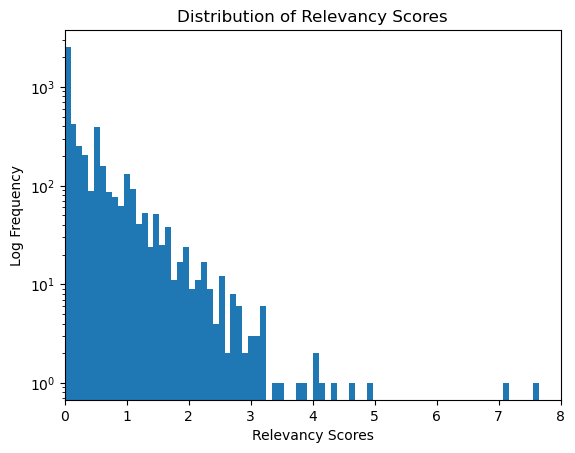

In [38]:
ax = prerankings["Relevancy Score"].plot(kind = 'hist', logy = True, bins = 80, title = "Distribution of Relevancy Scores",
                                    xlim = (0,8))
ax.set_xlabel("Relevancy Scores")
ax.set_ylabel("Log Frequency")


In [16]:
rankings
print("Done.")

Done.


In [17]:
REST_URL = "http://data.bioontology.org"
"""
Use of this requires a valid API Key.
This simply requires setting up an account at bioportal.bioonotology.org,
but do note that API Keys are meant to be secret, and probably more permanent than
what amounts to basically an intern's key.
"""
API_KEY = "0de90ddd-0da2-42ee-b0a0-2eb3b90dface"
ont = "HP,MDM"
def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

abstract = "Ivermectin (IVM) is an antiparasitic drug that is widely used in domestic animals. In mammals, IVM acts as a γ-aminobutyric acid (GABA) receptor agonist. This neurotransmitter plays an important role in the regulation of female sexual behavior. The present study investigated the effects of therapeutic (0.2 mg/kg) and high (1.0 mg/kg) IVM doses on female sexual behavior in physiological and pharmacological conditions. Female rats in estrus or treated with estradiol valerate to induce sexual behavior 24 h before the experiments were used. Ivermectin was administered 15 min before the sexual observations. The number of lordosis events in 10 mounts was recorded to calculate the lordosis quotient. The intensity of lordosis (0 [no lordosis], 1 [low lordosis], 2 [normal lordosis] and 3 [exaggerated lordosis]) was scored. In estrus and hormonal treated female rats, both IVM doses decreased the intensity of the lordosis reflex and the percentage of females that presented high levels of lordosis (exaggerated lordosis). However, the number of females that presented lordosis was unaltered. We conclude that in both hormonal conditions, 0.2mg/kg IVM treatment reduced female sexual behavior and the execution of the lordosis reflex. The present results may be useful for avoiding the side effects of this drug in veterinary practice."
annotations = get_json(REST_URL + "/annotator?text=" + urllib.parse.quote(abstract) + "&ontologies=" + ont)

In [18]:
def print_annotations(annotations, get_class=True):
    for result in annotations:
        class_details = result["annotatedClass"]
        if get_class:
            try:
                class_details = get_json(result["annotatedClass"]["links"]["self"])
            except urllib.error.HTTPError:
                print(f"Error retrieving {result['annotatedClass']['@id']}")
                continue
        print("Class details")
        print("\tid: " + class_details["@id"])
        print("\tprefLabel: " + class_details["prefLabel"])
        print("\tontology: " + class_details["links"]["ontology"])

        print("Annotation details")
        for annotation in result["annotations"]:
            print("\tfrom: " + str(annotation["from"]))
            print("\tto: " + str(annotation["to"]))
            print("\tmatch type: " + annotation["matchType"])

        if result["hierarchy"]:
            print("\n\tHierarchy annotations")
            for annotation in result["hierarchy"]:
                try:
                    class_details = get_json(annotation["annotatedClass"]["links"]["self"])
                except urllib.error.HTTPError:
                    print(f"Error retrieving {annotation['annotatedClass']['@id']}")
                    continue
                pref_label = class_details["prefLabel"] or "no label"
                print("\t\tClass details")
                print("\t\t\tid: " + class_details["@id"])
                print("\t\t\tprefLabel: " + class_details["prefLabel"])
                print("\t\t\tontology: " + class_details["links"]["ontology"])
                print("\t\t\tdistance from originally annotated class: " + str(annotation["distance"]))

        print("\n\n")
        
#print_annotations(annotations)

In [19]:
"""
Documentation for ann_extraction()

This function's purpose is to feed the queried abstracts into different bioontology databases for annotation and extract the terms found within.
Calls getAnnotations() for parsing o results and formatting.

Arguments:
    * ont: List of codes determining which ontologies to annotate from.
    * table: Pandas dataframe of records pulled from query.
Return Value: rankedAnnotations, a list of dictionaries with annotated terms separated by source ontology that can be set added as columns to the dataframe of choice.
"""
def ann_extraction(ont, table):
    #i = 0
    rankedAnnotations = []
    ranking = table
    for abstract in ranking["Abstract"]:
        #i = i +1
        #print("ABSTRACT " + str(i))
        annotations = (get_json(REST_URL + "/annotator?text=" + urllib.parse.quote(abstract) + "&ontologies=" 
                                + ont + "&roots_only=true&require_exact_match=true&exclude_synonyms=true"))
        rankedAnnotations.append(getAnnotations(annotations, ont))
         
    return rankedAnnotations
    
    
"""
Documentation for getAnnotations()

This function takes the returned JSON annotation objects from ann_extraction(), seperates the annotations by source ontology, and formats them for clean output.

Arguments:
    * ont: List of codes determining which ontologies to annotate from.
    * annotations: JSON formatted collection of annotation objects to be parsed for output.
Return Value: ontDict, a dictionary with the ontology codes as keys and a list of annotated terms from the source ontology as values.
"""
def getAnnotations(annotations, ont):
    ontCat = ont.split(",")
    ontDict={}
    for ont in ontCat:
        ontDict[ont] = []

    for result in annotations:
        class_details = result["annotatedClass"]
        try:
            class_details = get_json(result["annotatedClass"]["links"]["self"])
        except urllib.error.HTTPError:
            print(f"Error retrieving {result['annotatedClass']['@id']}")
            continue
        ontDict[str(class_details["links"]["ontology"].split("/")[-1])] += [class_details["prefLabel"]]
        

    return ontDict

columns = ann_extraction(ont, rankings)
top100_columns = ann_extraction(ont, top_100)

In [20]:
"""
Documentation for attachAnnotations()

This function takes the list of separated annotation dictionaries per abstract, checks for duplicates within each abstract, and formats them or attachment to the CSV.

Arguments:
    * ont: List of codes determining which ontologies to annotate from.
    * columns: List of dictionaries with separated annotations by ontology.
    * rankings: Dataframe of records from query.
Return Value: None
"""
#adds anotatons to rankings table
def attachAnnotations(ont, columns, rankings):

    sources = ont.split(",")
    for source in sources:
        cols = []
        for ele in columns:
            items = []
            temp = ele[source]
            for i in temp:
                if i not in items:
                    items.append(i)
            items = str(items)
            cols.append(items.strip("[]"))
        rankings[source] = cols
        
attachAnnotations(ont, columns, rankings)
attachAnnotations(ont, top100_columns, top_100)
#print(rankings)

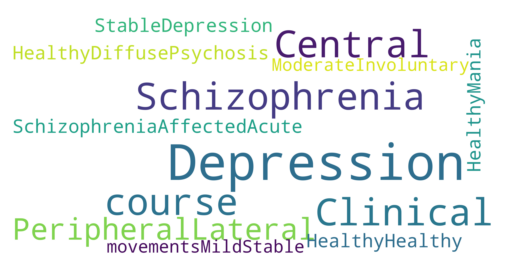

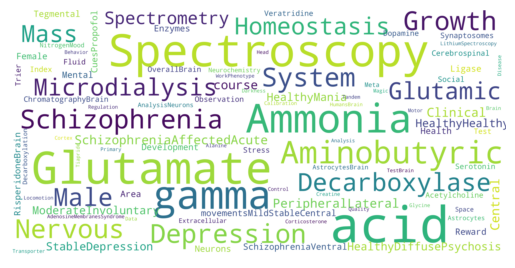

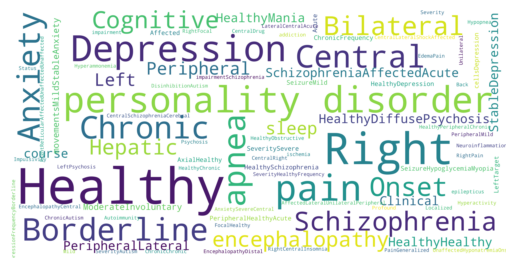

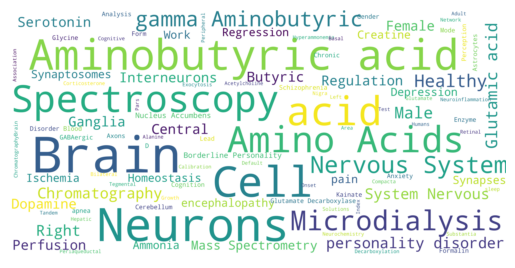

In [35]:
def generate_wordclouds(ont, rankings):
    sources = ont.split(",")
    text = ""
    
    for source in sources:
        temp = rankings[source]
        for items in temp:
            for element in items:
                text += element.strip("''")
       
        wordcloud = WordCloud(max_font_size=40, max_words=100, background_color="white", normalize_plurals = True, scale = 15 ).generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        wordcloud = WordCloud().generate(text)
        
    # Create and generate a word cloud image:
        
generate_wordclouds(ont, rankings)
generate_wordclouds(ont, top_100)

In [36]:
# CSV output
rankings.to_csv("Glutamate and GABA10.csv")
print("Done.")

Done.
